## 0. Import dependencies

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../utils')
from load_data import ames_housing

import functools
import tensorflow as tf
from tensorflow.python.feature_column.feature_column import _LazyBuilder
tf.__version__

'1.9.0'

## 1. Load data

In [2]:
datadf = pd.read_csv('../data/Ames-Housing/train.csv', keep_default_na=False)
testdf = pd.read_csv('../data/Ames-Housing/test.csv', keep_default_na=False)

datadf.set_index('Id', inplace=True)
testdf.set_index('Id', inplace=True)

labelkey = 'SalePrice'
ydata = np.array(datadf[labelkey]) 
datadf.drop(columns=[labelkey], inplace=True)

numvalid = 100
traindf = datadf[:-numvalid]
validdf = datadf[-numvalid:]
trainy = ydata[:-numvalid]
validy = ydata[-numvalid:]

numtrainsamp, numtrainfeat = traindf.shape
numvalidsamp, numvalidfeat = validdf.shape
numtestsamp, numtestfeat = testdf.shape
print("Number of train samples is {}.".format(numtrainsamp))
print("Number of valid samples is {}.".format(numvalidsamp))
print("Number of test samples is {}.".format(numtestsamp))

Number of train samples is 1360.
Number of valid samples is 100.
Number of test samples is 1459.


## 2. Define numeric and categorical feature columns

In [3]:
listnumeric = ['LotFrontage', 'LotArea', 'YearBuilt', 
               'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
               'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
               '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
               'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
               'FullBath', 'HalfBath', 'BedroomAbvGr', 
               'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
               'GarageYrBlt', 'GarageCars', 'GarageArea',
               'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
               '3SsnPorch', 'ScreenPorch', 'PoolArea',
               'MiscVal', 'YrSold']

dictcategorical = {'MSSubClass': [20, 30, 40, 45, 50, 
                                  60, 70, 75, 80, 85, 
                                  90, 120, 150, 160, 
                                  180, 190], 
                   'MSZoning': ['A', 'C', 'FV', 'I', 
                                'RH', 'RL', 'RP', 'RM'], 
                   'Street': ['Grvl', 'Pave'],
                   'Alley': ['Grvl', 'Pave', 'NA'],
                   'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'],
                   'LandContour': ['Lvl', 'Bnk', 'HLS', 'Low'],
                   'Utilities': ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'],
                   'LotConfig': ['Inside', 'Corner', 'CulDSac', 'FR2', 
                                 'FR3'],
                   'LandSlope': ['Gtl', 'Mod', 'Sev'],
                   'Neighborhood': ['Blmngtn', 'Blueste', 'BrDale',
                                    'BrkSide', 'ClearCr', 'CollgCr',
                                    'Crawfor', 'Edwards', 'Gilbert',
                                    'IDOTRR', 'MeadowV', 'Mitchel',
                                    'Names', 'NoRidge', 'NPkVill',
                                    'NridgHt', 'NWAmes', 'OldTown',
                                    'SWISU', 'Sawyer', 'SawyerW'
                                    'Somerst', 'StoneBr', 'Timber', 
                                    'Veenker'],
                   'Condition1': ['Artery', 'Feedr', 'Norm', 'RRNn',
                                  'RRAn', 'PosN', 'PosA', 'RRNe', 
                                  'RRAe'],
                   'Condition2': ['Artery', 'Feedr', 'Norm', 'RRNn',
                                  'RRAn', 'PosN', 'PosA', 'RRNe', 
                                  'RRAe'],
                   'BldgType': ['1Fam', '2FmCon', 'Duplx', 
                                'TwnhsE', 'TwnhsI'],
                   'HouseStyle': ['1Story', '1.5Fin', '1.5Unf',
                                  '2Story',  '2.5Fin','2.5Unf', 
                                  'SFoyer', 'SLvl'],
                   'OverallQual': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
                   'OverallCond': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
                   'RoofStyle': ['Flat', 'Gable', 'Gambrel', 'Hip',
                                 'Mansard', 'Shed'],
                   'RoofMatl': ['ClyTile', 'CompShg', 'Membran',
                                'Metal', 'Roll', 'Tar&Grv', 
                                'WdShake', 'WdShngl'],
                   'Exterior1st': ['AsbShng', 'AsphShn', 'BrkComm',
                                   'CBlock', 'CemntBd', 'HdBoard',
                                   'ImStucc', 'MetalSd', 'Other',
                                   'Plywood', 'PreCast', 'Stone', 
                                   'Stucco', 'VinylSd', 'Wd Sdng',
                                   'WdShing'],
                   'Exterior2nd': ['AsbShng', 'AsphShn', 'BrkComm',
                                   'CBlock', 'CemntBd', 'HdBoard',
                                   'ImStucc', 'MetalSd', 'Other',
                                   'Plywood', 'PreCast', 'Stone', 
                                   'Stucco', 'VinylSd', 'Wd Sdng',
                                   'WdShing'],
                   'MasVnrType': ['BrkCmn', 'BrkFace', 'CBlock',
                                  'None', 'Stone'],
                   'ExterQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
                   'ExterCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
                   'Foundation': ['BrkTil', 'CBlock', 'PConc',
                                  'Slab', 'Stone', 'Wood'],
                   'BsmtQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
                   'BsmtCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
                   'BsmtExposure': ['Gd', 'Av', 'Mn', 'No', 'NA'],
                   'BsmtFinType1': ['GLQ', 'ALQ', 'BLQ', 'Rec', 
                                    'LwQ', 'Unf', 'NA'],
                   'BsmtFinType2': ['GLQ', 'ALQ', 'BLQ', 'Rec', 
                                    'LwQ', 'Unf', 'NA'],
                   'Heating': ['Floor', 'GasA', 'GasW', 'Grav', 
                               'OthW', 'Wall'],
                   'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
                   'CentralAir': ['N', 'Y'],
                   'Electrical': ['SBrkr', 'FuseA', 'FuseF', 'FuseP',
                                  'Mix'],
                   'KitchenQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
                   'Functional': ['Typ', 'Min1', 'Min2', 'Mod', 
                                  'Maj1', 'Maj2', 'Sev', 'Sal'],
                   'FireplaceQu': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
                   'GarageType': ['2Types', 'Attchd', 'Basment',
                                  'BuiltIn', 'CarPort', 'Detchd',
                                  'NA'],
                   'GarageFinish': ['Fin', 'RFn', 'Unf', 'NA'],
                   'GarageQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
                   'GarageCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
                   'PavedDrive': ['Y', 'P', 'N'],
                   'PoolQC': ['Ex', 'Gd', 'TA', 'Fa', 'NA'],
                   'Fence': ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA'],
                   'MiscFeature': ['Elev', 'Gar2', 'Othr', 'Shed',
                                   'TenC', 'NA'],
                   'MoSold': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                   'SaleType': ['WD', 'CWD', 'VWD', 'New', 'COD',
                                'Con', 'ConLw', 'ConLI', 'ConLD',
                                'Oth'],
                   'SaleCondition': ['Normal', 'Abnorml', 'AdjLand',
                                     'Alloca', 'Family', 'Partial']
                  }

numfeatcols = len(list(dictcategorical.keys()))+len(listnumeric)
print("Number of feature columns is {}.".format(numfeatcols))

listcolumns = traindf.keys().tolist()
listcategorical = list(dictcategorical.keys())
print('Checking listnumeric ...')
print([num in listcolumns for num in listnumeric])
print("Checking dictcategorical ...")
print([cat in listcolumns for cat in listcategorical])

Number of feature columns is 79.
Checking listnumeric ...
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
Checking dictcategorical ...
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


## 3. Preprocess data 

In [4]:
def preprocess_numeric(df, listnumeric):
    """Preprocess data to avoid numeric data columns with string 'NA' """
    listcolumns = df.keys().tolist()
    for i, col in enumerate(listcolumns):
        if col in listnumeric:
            df.loc[:, col].replace('NA', -1, inplace=True)
            df.loc[:, col] = df.loc[:, col].apply(pd.to_numeric)
    return df

def normalize_numeric(traindf, validdf, testdf, listnumeric):
    """Normalize numeric data"""
    listcolumns = traindf.keys().tolist()
    for col in listcolumns:
        if col in listnumeric:
            miu = traindf[col].mean()
            sigma = traindf[col].std()
            traindf[col] = (traindf[col]-miu)/sigma
            validdf[col] = (validdf[col]-miu)/sigma
            testdf[col] = (testdf[col]-miu)/sigma
    return traindf, validdf, testdf

traindf = preprocess_numeric(traindf, listnumeric)
validdf = preprocess_numeric(validdf, listnumeric)
testdf = preprocess_numeric(testdf, listnumeric)
#traindf, validdf, testdf = normalize_numeric(traindf, validdf, testdf, listnumeric)

/home/ymtoo/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/ymtoo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## 4. Setting TensorFlow input data

In [5]:
def feature_column(listnumeric, dictcategorical):
    listcategorical = list(dictcategorical.keys())
    numeric_cols = []
    for num in listnumeric:
        numeric_cols.append(tf.feature_column.numeric_column(num))
    categorical_cols = []
    for cat in listcategorical:
        cattemp = tf.feature_column.categorical_column_with_vocabulary_list(
                cat, dictcategorical[cat])
        categorical_cols.append(cattemp)
    return numeric_cols, categorical_cols

numeric_cols , categorical_cols = feature_column(listnumeric, dictcategorical)
indicator_cols = list(map(tf.feature_column.indicator_column, categorical_cols))

### 4.1 Test input data

In [6]:
test = {'MSZoning': ['A', 'C', 'KK']}

dense_tensor = tf.feature_column.input_layer(test, [indicator_cols[1]])
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    print(session.run([dense_tensor]))

[array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)]


## 5. Linear regressor

In [7]:
def easy_input_fn(df, label, num_epochs, shuffle, batch_size):
    if label is None:
        inputs = dict(df)
    else:
        inputs = (dict(df), label)
    ds = tf.data.Dataset.from_tensor_slices(inputs)
    
    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds

train_inpf =  functools.partial(easy_input_fn, 
                                traindf,
                                label=trainy,  
                                num_epochs=50, 
                                shuffle=True, 
                                batch_size=64)

valid_inpf =  functools.partial(easy_input_fn, 
                                validdf, 
                                label=validy,
                                num_epochs=1, 
                                shuffle=True, 
                                batch_size=64)

test_inpf =  functools.partial(easy_input_fn, 
                               validdf, 
                               label=None,
                               num_epochs=1, 
                               shuffle=True, 
                               batch_size=64)

reg = tf.estimator.LinearRegressor(feature_columns=numeric_cols+categorical_cols)
reg.train(train_inpf)
result = reg.evaluate(valid_inpf)

for key,value in sorted(result.items()):
    print('%s: %0.2f' % (key, value))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpory2esnx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f49cd491390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpory2esnx/model.ckpt.
INFO:ten

In [8]:
pred = reg.predict(valid_inpf)
validypred = np.zeros((validy.size))
for i, p in enumerate(pred):
    validypred[i] = p['predictions'][0]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpory2esnx/model.ckpt-1100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


## 6. Plot result

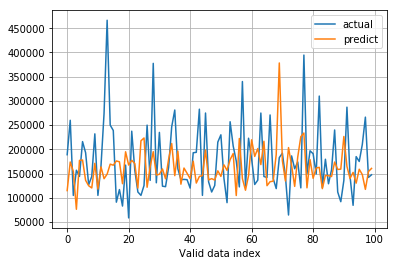

In [13]:
fig, ax = plt.subplots()
ax.plot(validy, label='actual')
ax.plot(validypred, label='predict')
ax.set_xlabel('Valid data index')
ax.grid()
ax.legend()